In [1]:
import argparse
import os
from random import shuffle
import shutil
import subprocess
import sys
import itertools
import numpy as np
import cv2
import matplotlib.pyplot as plt
import plotly.plotly as py
import matplotlib.patches as mpatches
import cv2
import seaborn as sns

In [2]:
data_set_path = "/home/ubuntu/okutama17" # set the dataset path



gt_path = data_set_path + "/gt/"
classes = ['Walking','Sitting','Standing','Running','Lying','Carrying','Pushing/Pulling','Reading',
           'Drinking','Calling','Hand Shaking', 'Hugging']
priority = ['Hand Shaking', 'Hugging', 'Drinking', 'Calling', 'Reading', 'Pushing/Pulling', 
            'Carrying', 'Lying', 'Running', 'Sitting', 'Walking', 'Standing']

action_dt = np.dtype([(i,int) for i in classes])
keys = ['TrackID','xmin','ymin','xmax','ymax','frame','lost','occluded','generated']
bbox_dt = np.dtype([(i,int) for i in keys] + [('actions', action_dt)]) 

In [3]:
def load_bbox(gt):
    ret = []
    with open(gt,'r') as f:
        for line in f:
            bbox = np.zeros((1,),dtype=bbox_dt)
            spt = line.split(" ")
            for ind, val in enumerate(spt):
                if ind < 9:
                    bbox[keys[ind]] = val
            spt = line.split("\"")
            for val in spt[1::2]:
                if not val in ["Person","Leaving Cars/Buildings", "Entering Cars/Buildings"]:
                    if val == 'Pushing/Pulling Something' or val == "Pushing Something" or val == 'Pushing Someone':
                        val = "Pushing/Pulling"
                    if val == "Delivering":
                        val = 'Carrying'
                    bbox['actions'][val] = 1
            # pick only the action with the highest priority        
            flag = False
            for i in priority:
                if flag:
                    bbox['actions'][i] = 0
                flag = flag or (bbox['actions'][i] == 1)
                
            ret.append(bbox)
    return np.array(ret,dtype=bbox_dt)

def normalize(inp):
    st_dt = np.dtype([(i,float) for i in classes])
    y = np.zeros(1, dtype=st_dt)
    sm = 0.0
    for i in classes:
        sm += inp[i]
    for i in classes:
        y[i] = inp[i] * 100.0 / sm
    print sm 
    return y[0]

def compute_statistics(names,sort=False):
    total_frames = np.zeros(1, dtype=action_dt)
    average_action_length = np.zeros(1, dtype=action_dt)[0]
    action_instances = np.zeros(1, dtype=action_dt)[0]
    for video_id in names:
        if video_id != "2.1.11":
                print "Loading:", video_id
                gt = load_bbox(gt_path+video_id+'.txt')
                
                for i in xrange(gt[-1]["TrackID"]+1):
                    min_frame = gt[gt["TrackID"]==i]["frame"][0]
                    mask = np.logical_not(np.logical_and(gt["TrackID"]==i , gt["frame"]>(180+min_frame)))
                    gt = gt[mask]
                
                gt = gt[gt['lost']==0]
                gt = gt[gt['occluded']==0]
                
                for action in classes:
                    total_frames[action] += gt[:]['actions'][action].sum()
                ind = 0
                while ind < len(gt):
                    entry = gt[ind]
                    action = [classes[i] for i, item in enumerate(entry['actions']) if item == 1]
                    if len(action) == 0:
                        ind += 1
                        continue
                    action = action[0]
                    length = 1
                    for entry2 in gt[ind+1:]:
                        if not((entry['TrackID'] == entry2['TrackID']) 
                               and (entry['actions'][action] + entry2['actions'][action] == 2)):
                            break
                        length +=1
                    action_instances[action] += 1
                    average_action_length[action] += length / 30.0
                    ind += length
    
    pair_total_sec = [(total_frames[0][i]/30.0, i) for i in classes]
    pair_action_instances = [(action_instances[i], i) for i in classes]
    pair_average_action_length = [(average_action_length[i] / float(action_instances[i]), i)for i in classes]
    if sort:
        return sorted(pair_total_sec), sorted(pair_action_instances), sorted(pair_average_action_length)
    return pair_total_sec, pair_action_instances, pair_average_action_length
    
                    
def draw_single(actions, y, name=""):                    
    plt.style.use('seaborn-white')
    fig = plt.gcf()
    fig.set_size_inches(20, 18)
    ax = plt.axes()        
    ax.yaxis.grid()

    x = range(len(actions))
    x_label = [(i+0.33) for i in xrange(len(actions))]
    print actions
    print y
    plt.bar(x, y)
    plt.xticks(x_label, classes, rotation=60,fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel("Time (sec)", rotation=90,fontsize=20)
    if name != "":
        plt.savefig(name+".pdf")
    plt.show()

def create_XML_Detection(names):
    for video_id in names:
        if video_id != "2.1.11":
            print "Loading:", video_id
            bboxes = load_bbox(gt_path + video_id + '.txt')
            
            for i in xrange(bboxes[-1]["TrackID"]+1):
                min_frame = bboxes[bboxes["TrackID"]==i]["frame"][0]
                mask = np.logical_not(np.logical_and(bboxes["TrackID"]==i , bboxes["frame"]>(180+min_frame)))
                bboxes = bboxes[mask]
                
            bboxes_sorted = np.sort(bboxes, order='frame')
#            bboxes_visible = bboxes_sorted[bboxes_sorted['generated']==0] # Do not use the interpolated annotations
            bboxes_visible = bboxes_sorted[bboxes_sorted['lost']==0] # Do not use the tracks that are not visible
            bboxes_visible = bboxes_visible[bboxes_visible['occluded']==0] # Or occluded   
            
            unique_frames = set(bboxes_visible['frame'])
            
            img = cv2.imread(os.path.join(data_set_path, video_id, "images",'0.jpg'))
            height, width, depth = img.shape
            for frame in sorted(unique_frames):
                # Create the annotation file for each frame in bboxes_visible
                os.system("mkdir " +os.path.join(data_set_path, video_id, "human-detection"))
                with open(os.path.join(data_set_path, video_id, "human-detection", str(frame) + '.xml'), 'w') as f:
                    print >>f, "<annotation>"
                    print >>f, "<folder>", os.path.join(data_set_path, video_id, "images") , "</folder>"
                    print >>f, "<filename>", str(frame)+".jpg", "</filename>"
                    print >>f, "<size>"
                    print >>f, "<width>", str(width), "</width>"
                    print >>f, "<height>", str(height), "</height>"
                    print >>f, "<depth>", str(depth), "</depth>"
                    print >>f, "</size>"
                    for bbox in bboxes_visible[bboxes_visible['frame']==frame]:
                        print >>f, "<object>"
                        print >>f, "<name>Person</name>"
                        print >>f, "<pose>Unspecified</pose>"
                        print >>f, "<truncated>0</truncated>"
                        print >>f, "<difficult>0</difficult>"
                        print >>f, "<bndbox>"
                        print >>f, "<xmin>", str(bbox["xmin"]), "</xmin>"
                        print >>f, "<xmax>", str(bbox["xmax"]), "</xmax>"
                        print >>f, "<ymin>", str(bbox["ymin"]), "</ymin>"
                        print >>f, "<ymax>", str(bbox["ymax"]), "</ymax>"
                        print >>f, "</bndbox>"
                        print >>f, "</object>"
                    print >>f, "</annotation>"
                    
                    
def create_XML_Action(names):
    for video_id in names:
        if video_id != "2.1.11":
            print "Loading:", video_id
            bboxes = load_bbox(gt_path + video_id + '.txt')
            
            for i in xrange(bboxes[-1]["TrackID"]+1):
                min_frame = bboxes[bboxes["TrackID"]==i]["frame"][0]
                mask = np.logical_not(np.logical_and(bboxes["TrackID"]==i , bboxes["frame"]>(180+min_frame)))
                bboxes = bboxes[mask]
                
            bboxes_sorted = np.sort(bboxes, order='frame')
            
            #bboxes_visible = bboxes_sorted[bboxes_sorted['lost']==0] # Do not use the tracks that are not visible
            #bboxes_visible = bboxes_visible[bboxes_visible['occluded']==0] # Or occluded
            
            unique_frames = len(os.listdir(os.path.join(data_set_path, video_id, "images")))
            print unique_frames
            
            img = cv2.imread(os.path.join(data_set_path, video_id, "images",'0.jpg'))
            height, width, depth = img.shape
            
            os.system("mkdir " +os.path.join(data_set_path, video_id, "action-detection"))
            for frame in xrange(unique_frames):
                # Create the annotation file for each frame in bboxes_visible
                with open(os.path.join(data_set_path, video_id, "action-detection", str(frame) + '.xml'), 'w') as f:
                    print >>f, "<annotation>"
                    print >>f, "<folder>", os.path.join(data_set_path, video_id, "images") , "</folder>"
                    print >>f, "<filename>", str(frame)+".jpg", "</filename>"
                    print >>f, "<size>"
                    print >>f, "<width>", str(width), "</width>"
                    print >>f, "<height>", str(height), "</height>"
                    print >>f, "<depth>", str(depth), "</depth>"
                    print >>f, "</size>"
                    for bbox in bboxes_sorted[bboxes_sorted['frame']==frame]:
                        action = "none"
                        for i in classes:
                            if bbox['actions'][i] == 1:
                                action = i
                                break
                        if bbox["lost"] == 1 or bbox["occluded"] == 1 or action == "none":
                            continue
                        print >>f, "<object>"
                        print >>f, "<name>"+action+"</name>"
                        print >>f, "<pose>Unspecified</pose>"
                        print >>f, "<truncated>0</truncated>"
                        print >>f, "<difficult>0</difficult>"
                        print >>f, "<bndbox>"
                        print >>f, "<xmin>", str(bbox["xmin"]), "</xmin>"
                        print >>f, "<xmax>", str(bbox["xmax"]), "</xmax>"
                        print >>f, "<ymin>", str(bbox["ymin"]), "</ymin>"
                        print >>f, "<ymax>", str(bbox["ymax"]), "</ymax>"
                        print >>f, "</bndbox>"
                        print >>f, "</object>"
                    print >>f, "</annotation>"
                    
def create_list(names, task ,split_name):
    with open(split_name, 'w') as f:
        for video_id in names:
            for root, subdirs, files in os.walk(os.path.join(data_set_path, video_id, task)):
                for annot in files:
                    print >>f, os.path.join(data_set_path, video_id, "images",annot.split(".")[0]+".jpg"), os.path.join(root,annot)
def generate_list():
    test_set = ["1.8","1.9","1.11","2.1","2.3","2.10"]
    test_lst = [str(i)+"."+name for i in xrange(1,3) for name in test_set]
    
    trainval_set = [str(i)+"."+str(j) for i in xrange(1,3) for j in xrange(1,12) if not str(i)+"."+str(j) in test_set]
    trainval_lst = [str(i)+"."+name for i in xrange(1,3) for name in trainval_set]
    return trainval_lst, test_lst

def draw_stacked(actions, stats1, stats2, name=""):
    fig = plt.gcf()
    fig.set_size_inches(20, 18)
    plt.style.use('ggplot')
    x = range(len(actions))
    plt.bar(x, stats1, color=(0.2588,0.4433,1.0))
    plt.bar(x, stats2, color=(1.0,0.5,0.62), bottom=stats1)
    plt.xticks(x, actions, rotation=60,fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel("Time (sec)", rotation=90,fontsize=20)
    
    red_patch = mpatches.Patch(color='red', label='Test data')
    blue_patch = mpatches.Patch(color='blue', label='Trainval data')
    plt.legend(handles=[red_patch,blue_patch],fontsize=20)

    if name != "":
        plt.savefig(name+".pdf")
    
    plt.show()
    
def create_list_flow(names, split_name):
    with open(split_name, 'w') as f:
        for video_id in names:
            for root, subdirs, files in os.walk(os.path.join(data_set_path, video_id, 'action-detection')):
                for annot in files:
                    print >>f, os.path.join(data_set_path, 'cvof', video_id, "images", annot.split(".")[0]+".jpg"), os.path.join(root,annot)
def calculate_mean(names):
    mean = np.zeros((921600, 3))
    cnt = 0.0
    for video_id in names:
        if video_id != "2.1.11":
            print "Loading ...", video_id
            path = os.path.join(data_set_path, 'cvof',video_id,"images")
            for f in os.listdir(path):
                cnt += 1
                im = cv2.imread(os.path.join(path,f))
                mean += im.reshape(-1,3)
    mean = np.sum(mean,axis=0)/cnt
    return mean/921600.0    

In [ ]:
lst_all =  [str(i)+"."+str(j)+"."+str(k) for i in range(1,3) for j in range(1,3) for k in range(1,12) ]
#create_XML_Detection(lst)
#print "finish creating XML Files"
create_XML_Action(lst_all)
print "Creating XML files is finished"

In [ ]:
# test_set = ["1.8","1.9","1.11","2.1","2.3","2.10"]
# lst = [str(i)+"."+name for i in xrange(1,3) for name in test_set]
# create_list(lst, "action-detection","test_action.txt")
# trainval_set = [ str(i)+"."+str(j) for i in xrange(1,3) for j in xrange(1,12) if not str(i)+"."+str(j) in test_set ]
# lst = [str(i)+"."+name for i in xrange(1,3) for name in trainval_set]
# create_list(lst, "action-detection","trainval_action.txt")
trainval_lst, test_lst = generate_list()
create_list_flow(names=trainval_lst, split_name = 'trainval_flow.txt')
create_list_flow(names=test_lst, split_name = 'test_flow.txt')

In [ ]:
trainval_lst, test_lst = generate_list()
trainval_pair = compute_statistics(trainval_lst)
test_pair = compute_statistics(test_lst)

In [ ]:
stats1, actions = zip(*trainval_pair)
stats2, _ = zip(*test_pair)

draw_stacked(actions, stats1, stats2 , "together-2")

In [ ]:
print calculate_mean(trainval_lst)

In [4]:
all_lst =  [str(i)+"."+str(j)+"."+str(k) for i in range(1,3) for j in range(1,3) for k in range(1,12) ]
pair_total_sec, pair_action_instances, pair_average_action_length = compute_statistics(all_lst)


Loading: 1.1.1
Loading: 1.1.2
Loading: 1.1.3
Loading: 1.1.4
Loading: 1.1.5
Loading: 1.1.6
Loading: 1.1.7
Loading: 1.1.8
Loading: 1.1.9
Loading: 1.1.10
Loading: 1.1.11
Loading: 1.2.1
Loading: 1.2.2
Loading: 1.2.3
Loading: 1.2.4
Loading: 1.2.5
Loading: 1.2.6
Loading: 1.2.7
Loading: 1.2.8
Loading: 1.2.9
Loading: 1.2.10
Loading: 1.2.11
Loading: 2.1.1
Loading: 2.1.2
Loading: 2.1.3
Loading: 2.1.4
Loading: 2.1.5
Loading: 2.1.6
Loading: 2.1.7
Loading: 2.1.8
Loading: 2.1.9
Loading: 2.1.10
Loading: 2.2.1
Loading: 2.2.2
Loading: 2.2.3
Loading: 2.2.4
Loading: 2.2.5
Loading: 2.2.6
Loading: 2.2.7
Loading: 2.2.8
Loading: 2.2.9
Loading: 2.2.10
Loading: 2.2.11


('Walking', 'Sitting', 'Standing', 'Running', 'Lying', 'Carrying', 'Pushing/Pulling', 'Reading', 'Drinking', 'Calling', 'Hand Shaking', 'Hugging')
(2362.6333333333332, 1154.8666666666666, 2705.5333333333333, 358.5, 417.69999999999999, 2203.8666666666668, 1263.5999999999999, 1112.4666666666667, 191.33333333333334, 593.26666666666665, 244.46666666666667, 273.76666666666665)


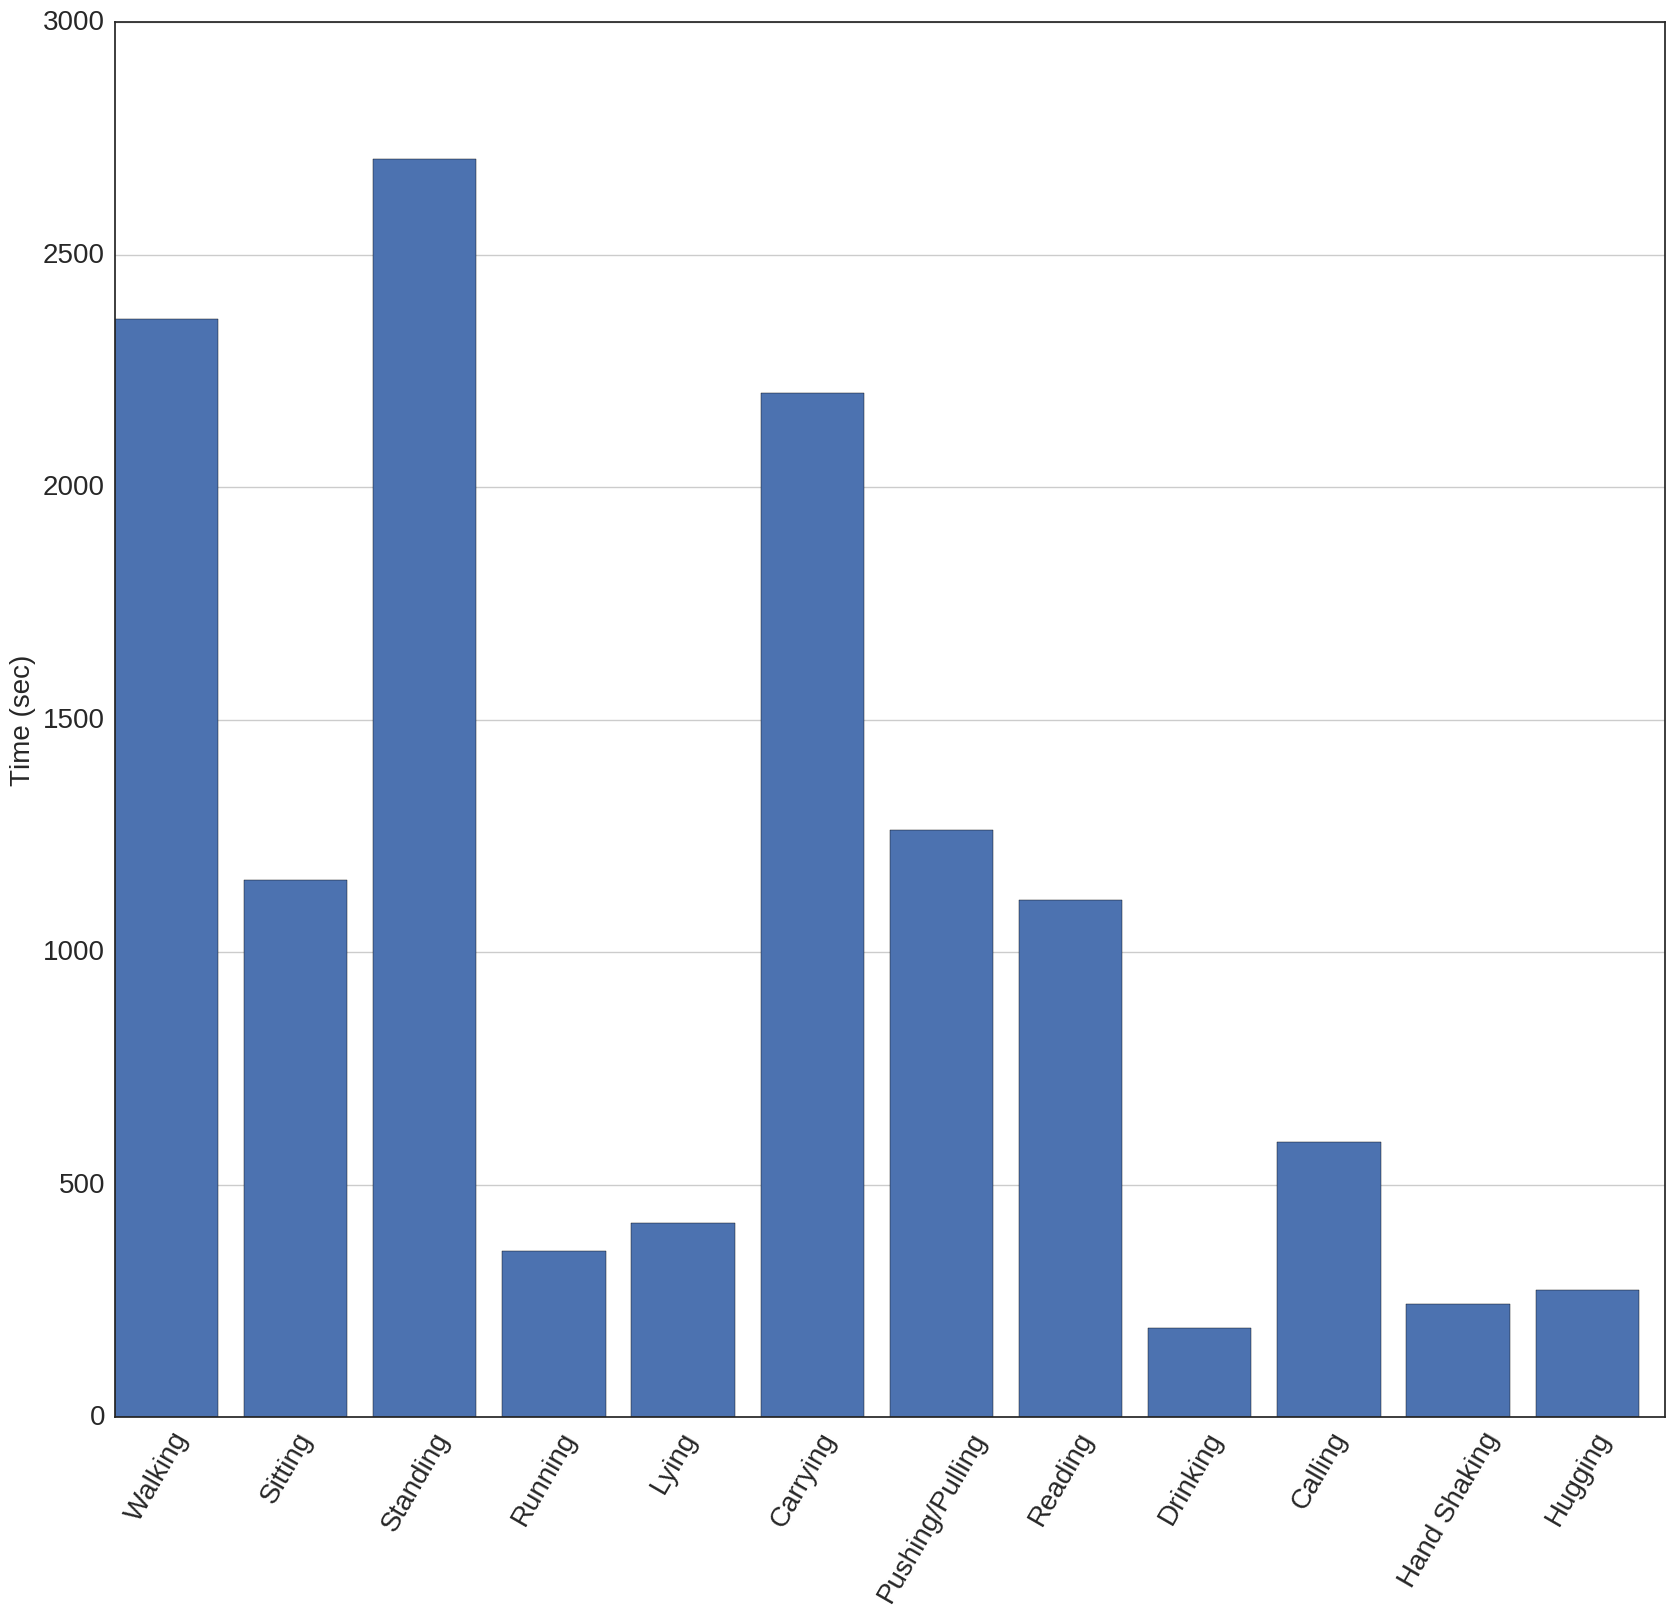

In [5]:
stats, actions = zip(*pair_total_sec)
draw_single(actions, stats, "test")






In [ ]:
def draw_together(actions, y, name="", save=False):                    
    plt.style.use('seaborn-white')
    fig = plt.gcf()
    fig.set_size_inches(20, 18)
    ax = plt.axes()        
    ax.yaxis.grid()

    x = range(len(actions))
    x_label = [(i+0.33) for i in xrange(len(actions))]
    print actions
    print y
    plt.bar(x, y)
    plt.xticks(x_label, classes, rotation=60,fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel("Time (sec)", rotation=90,fontsize=20)
    if save:
        plt.savefig(name+".pdf")
    plt.show()